In [1]:
!pip install matplotlib wordcloud


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from wordcloud import WordCloud

from collections import defaultdict
# %matplotlib inline

### READING ANIMELIST.CSV

In [3]:
import os

In [4]:
INPUT_DIR = os.path.join("../", "artifacts/", "raw/")

In [5]:
rating_df = pd.read_csv(INPUT_DIR+"animelist.csv", low_memory=True, usecols=["user_id", "anime_id", "rating"])
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
rating_df.shape

(5000000, 3)

### DATA PROCESSING

In [7]:
n_ratings = rating_df.user_id.value_counts()
n_ratings

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
106          1
6846         1
92           1
26           1
10703        1
Name: count, Length: 15186, dtype: int64

In [8]:
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >=400].index)].copy()

In [9]:
rating_df.shape

(3246641, 3)

In [10]:
rating_df

,user_id,anime_id,rating
213,2,24833,0
214,2,235,10
215,2,36721,0
216,2,40956,0
217,2,31933,0
...,...,...,...
4999916,16507,8985,0
4999917,16507,5454,0
4999918,16507,15911,0
4999919,16507,878,0


In [11]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])

print(f"Min. Rating: {min_rating} \nMax. Rating: {max_rating}")

Min. Rating: 0 
Max. Rating: 10


In [12]:
avg_rating = np.mean(rating_df["rating"])

print(f"Min. Rating: {avg_rating:.2f}")

Min. Rating: 4.12


#### Mean Max Feature Scaling to scale the ratings from 0 - 10 to 0 - 1

In [13]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [14]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])
avg_rating = np.mean(rating_df["rating"])
print(f"Min. Rating: {min_rating} \nMax. Rating: {max_rating} \nMin. Rating: {avg_rating:.3f}")

Min. Rating: 0.0 
Max. Rating: 1.0 
Min. Rating: 0.412


In [15]:
rating_df.duplicated().sum()

np.int64(0)

In [16]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

#### Encoding User IDs

In [17]:
user_id = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in  enumerate(user_id)}
user2user_decoded = {i: x for i, x in  enumerate(user_id)}

In [18]:
print(user2user_encoded)
print(user2user_decoded)

{2: 0, 6: 1, 12: 2, 16: 3, 17: 4, 19: 5, 21: 6, 41: 7, 42: 8, 44: 9, 47: 10, 53: 11, 55: 12, 60: 13, 66: 14, 73: 15, 74: 16, 85: 17, 89: 18, 90: 19, 94: 20, 98: 21, 102: 22, 108: 23, 111: 24, 112: 25, 120: 26, 121: 27, 122: 28, 135: 29, 145: 30, 146: 31, 147: 32, 153: 33, 155: 34, 156: 35, 172: 36, 174: 37, 184: 38, 190: 39, 193: 40, 194: 41, 198: 42, 204: 43, 205: 44, 209: 45, 214: 46, 219: 47, 222: 48, 227: 49, 228: 50, 235: 51, 238: 52, 240: 53, 243: 54, 248: 55, 251: 56, 252: 57, 257: 58, 264: 59, 267: 60, 272: 61, 274: 62, 275: 63, 284: 64, 285: 65, 286: 66, 290: 67, 291: 68, 293: 69, 300: 70, 301: 71, 306: 72, 308: 73, 310: 74, 313: 75, 314: 76, 316: 77, 320: 78, 321: 79, 324: 80, 325: 81, 326: 82, 327: 83, 330: 84, 336: 85, 340: 86, 345: 87, 346: 88, 349: 89, 350: 90, 366: 91, 367: 92, 371: 93, 372: 94, 375: 95, 381: 96, 382: 97, 386: 98, 389: 99, 398: 100, 405: 101, 406: 102, 413: 103, 414: 104, 418: 105, 423: 106, 426: 107, 428: 108, 431: 109, 432: 110, 436: 111, 437: 112, 438

In [19]:
len(user2user_encoded)

4203

In [20]:
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)
rating_df

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0
...,...,...,...,...
4999916,16507,8985,0.0,4202
4999917,16507,5454,0.0,4202
4999918,16507,15911,0.0,4202
4999919,16507,878,0.0,4202


#### Encoding Anime IDs

In [21]:
anime_id = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_id)}
anime2anime_decoded = {i: x for i, x in enumerate(anime_id)}

In [22]:
print(anime2anime_encoded)
print(anime2anime_decoded)
print(len(anime2anime_encoded))

{24833: 0, 235: 1, 36721: 2, 40956: 3, 31933: 4, 5042: 5, 7593: 6, 21: 7, 35446: 8, 24: 9, 22: 10, 38034: 11, 17251: 12, 5762: 13, 31580: 14, 33253: 15, 35028: 16, 9513: 17, 368: 18, 11633: 19, 31964: 20, 33486: 21, 31740: 22, 1470: 23, 1575: 24, 2904: 25, 1535: 26, 28223: 27, 226: 28, 38671: 29, 32872: 30, 15: 31, 71: 32, 7661: 33, 245: 34, 263: 35, 5258: 36, 270: 37, 24703: 38, 15451: 39, 8074: 40, 11061: 41, 28961: 42, 34542: 43, 14719: 44, 20899: 45, 26055: 46, 34933: 47, 37086: 48, 1604: 49, 22535: 50, 189: 51, 34599: 52, 29575: 53, 10620: 54, 32182: 55, 23755: 56, 20: 57, 1735: 58, 35581: 59, 5040: 60, 30276: 61, 34134: 62, 6893: 63, 11499: 64, 29786: 65, 16498: 66, 28171: 67, 32282: 68, 9253: 69, 3455: 70, 22319: 71, 10851: 72, 40658: 73, 29809: 74, 25397: 75, 2852: 76, 1635: 77, 1636: 78, 40337: 79, 39085: 80, 857: 81, 9721: 82, 36625: 83, 6987: 84, 8577: 85, 9849: 86, 4010: 87, 16642: 88, 41261: 89, 30614: 90, 4600: 91, 31101: 92, 4358: 93, 39068: 94, 10697: 95, 2251: 96, 3266

In [23]:
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)
rating_df

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4
...,...,...,...,...,...
4999916,16507,8985,0.0,4202,2533
4999917,16507,5454,0.0,4202,817
4999918,16507,15911,0.0,4202,2455
4999919,16507,878,0.0,4202,2154


#### Introduce Randomness to the DataFrame


In [24]:
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)

#### Splitting the DataFrame into Input and Output Features

In [25]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [26]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"]

#### Splitting the DataFrame into Train and Test Sets

In [27]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [28]:
X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [29]:
print(f"Length X_train: {len(X_train)} \nLength X_test: {len(X_test)}")

Length X_train: 3245641 
Length X_test: 1000


In [30]:
type(X_train)

numpy.ndarray

#### Creating Arrays for User and Anime Features

In [31]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [32]:
X_train_array

[array([ 120, 1195, 1591, ...,  368, 2198,   81]),
 array([1377, 1216, 1239, ...,  861, 2402, 1262])]

In [33]:
type(X_train_array[0])

numpy.ndarray

### MODEL ARCHITECTURE  

In [34]:
def RecommenderNet():
    embedding_size = 128  # size of the dense embedding vectors for both users and items

    # input for the user ID, shape [1] means one integer per example
    user = Input(name="user", shape=[1])
    # map each user ID to a dense vector of length embedding_size
    user_embedding = Embedding(
        name="user_embedding",
        input_dim=len(user_id),  # number of unique users
        output_dim=embedding_size  # dimension of embedding
    )(user)

    # input for the anime ID, one integer per example
    anime = Input(name="anime", shape=[1])
    # map each anime ID to a dense vector of length embedding_size
    anime_embedding = Embedding(
        name="anime_embedding",
        input_dim=len(anime_id),  # number of unique anime titles
        output_dim=embedding_size  # dimension of embedding
    )(anime)

    # compute cosine similarity between user and anime embeddings
    # axes=2 means we match on the embedding dimension
    x = Dot(name="dot_product", normalize=True, axes=2)(
        [user_embedding, anime_embedding]
    )

    # Flatten turns the result from shape (batch, 1, 1) into (batch, 1)
    x = Flatten()(x)

    # final dense layer to produce a single score per user–anime pair
    x = Dense(
        1,
        kernel_initializer="he_normal"  # He normal initializer for the weights
    )(x)
    # normalise the output distribution
    x = BatchNormalization()(x)
    # convert the output score into a probability between 0 and 1
    x = Activation("sigmoid")(x)

    # assemble the model, specifying inputs and outputs
    model = Model(inputs=[user, anime], outputs=x)
    # compile with binary crossentropy loss, track mae and mse, and use Adam optimizer
    model.compile(
        loss="binary_crossentropy",
        metrics=["mae", "mse"],
        optimizer="Adam"
    )

    return model


In [35]:
model = RecommenderNet()

In [36]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

#### Callbacks

In [37]:
start_lr = 0.0001
min_lr = 0.0001
max_lr = 0.0005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    '''This functions helps to find the best learning rate for the model'''
    if epoch < ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch < ramup_epochs + sustain_epochs:
        return max_lr
    else:
        return(max_lr-min_lr) * exp_decay**(epoch-ramup_epochs-sustain_epochs) + min_lr 

In [38]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch), verbose=0)

checkpoint_filepath = "./weights.weights.h5"
model_Checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor="val_loss", mode="min", save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor="val_loss", mode="min", restore_best_weights=True)

In [39]:
my_callbacks = [model_Checkpoint, lr_callback, early_stopping]

#### Model Training

In [40]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size, 
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - loss: 0.7932 - mae: 0.3808 - mse: 0.1949 - val_loss: 0.7130 - val_mae: 0.3649 - val_mse: 0.1651 - learning_rate: 1.0000e-04
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 0.7560 - mae: 0.3658 - mse: 0.1798 - val_loss: 0.7130 - val_mae: 0.3472 - val_mse: 0.1625 - learning_rate: 1.8000e-04
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - loss: 0.6391 - mae: 0.3066 - mse: 0.1294 - val_loss: 0.5992 - val_mae: 0.2772 - val_mse: 0.1124 - learning_rate: 2.6000e-04
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 0.5637 - mae: 0.2611 - mse: 0.0963 - val_loss: 0.5653 - val_mae: 0.2589 - val_mse: 0.0978 - learning_rate: 3.4000e-04
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 0.5341 - mae: 0.2416 - mse: 0.0838 - val_loss: 0.5455 - val_mae: 0.2464 - val_mse: 0.0898 - learning_rate: 4.2000e-04
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - loss: 0.5095 - mae: 0.2243 - mse: 0.0739 - v

##### Graphical Representation of the Model

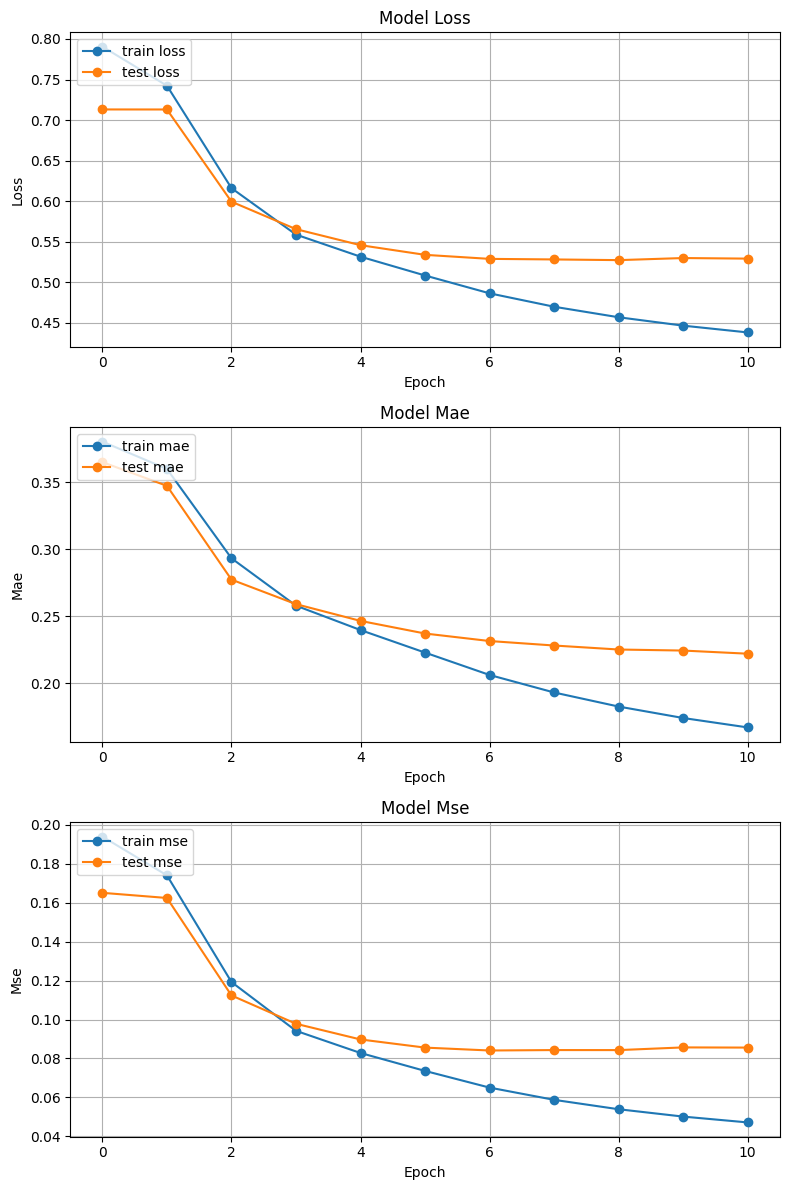

In [41]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-1], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-1], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

##### Extracting Weights

In [42]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis=1).reshape((-1, 1))
    return weights

In [43]:
anime_Weights = extract_weights("anime_embedding", model=model)

In [44]:
user_Weights = extract_weights("user_embedding", model=model)

### READING ANIMELIST.CSV

In [45]:
df = pd.read_csv(INPUT_DIR + "/anime.csv", low_memory=True)
df.head(3)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0


In [46]:
df = df.replace("Unknown", np.nan)

In [47]:
df["anime_id"] = df.MAL_ID

def get_anime_name(anime_id):
    try: 
        name = df[df.MAL_ID == anime_id]["English name"].values[0]
        if name is np.nan:
            name = df[df.MAL_ID == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [48]:
df["eng_version"] = df.anime_id.apply(lambda x:get_anime_name(x))

In [49]:
df.head(5)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [50]:
get_anime_name(6702)

'Fairy Tail'

In [51]:
df.sort_values(by="Score", inplace=True, ascending=False, kind="quicksort", na_position="last")
df.head(7)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4
6474,11061,Hunter x Hunter (2011),9.1,"Action, Adventure, Fantasy, Shounen, Super Power",Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,TV,148,"Oct 2, 2011 to Sep 24, 2014",Fall 2011,...,167331.0,65085.0,18241.0,7789.0,2780.0,1243.0,1054.0,4602.0,11061,Hunter x Hunter
6006,9969,Gintama',9.08,"Action, Sci-Fi, Comedy, Historical, Parody, Sa...",Gintama Season 2,銀魂',TV,51,"Apr 4, 2011 to Mar 26, 2012",Spring 2011,...,24294.0,9584.0,3222.0,1655.0,694.0,338.0,437.0,2910.0,9969,Gintama Season 2


In [52]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [53]:
df = df[["anime_id", "eng_version", "Score", "Genres", "Episodes", "Type", "Premiered", "Members"]]

In [54]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [55]:
def get_anime(df, anime):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    elif isinstance(anime, str):
        return df[df.eng_version.str.lower() == anime.lower()]

In [56]:
get_anime(df, "soul eater")

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3155,3588,Soul Eater,7.88,"Action, Fantasy, Comedy, Supernatural, Shounen",51,TV,Spring 2008,1218423


### READING ANIMEWITHSYNOPSIS.CSV

In [57]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]

In [58]:
synopsis_df = pd.read_csv(INPUT_DIR + "/anime_with_synopsis.csv", usecols=cols)

In [59]:
synopsis_df.head(2)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."


In [60]:
def get_synopsis(df, anime):
    try:
        if isinstance(anime,int):
            return df[df["MAL_ID"] == anime]["sypnopsis"].values[0]
        elif isinstance(anime, str):
            return df[df["Name"].str.lower() == anime.lower()]["sypnopsis"].values[0]
    except IndexError:
        print("Anime not found")
        return None

In [61]:
get_synopsis(synopsis_df, "Steins;gate")

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

## CONTENT/ITEM BASED RECOMMENDER SYSTEM

In [62]:
pd.set_option("max_colwidth", None)

In [63]:
def find_similar_animes(df, synopsis_df, name, anime_Weights, 
                        anime2anime_encoded, anime2anime_decoded, n=10,
                        return_dist=False, neg=False):
    try:
        index = get_anime(df, name).anime_id.values[0] #to get the natural index example >>> np.int64(2029)
        encoded_index = anime2anime_encoded.get(index)

        weights = anime_Weights

        dists = np.dot(weights, weights[encoded_index]) # find the similarity between all the anime weights and the current anime weight
        sorted_dist = np.argsort(dists) # returns an array of indices that would sort `dists` in ascending order. In other words

        n = n+1

        if neg:
            closest = sorted_dist[:n]
        else:
            closest = sorted_dist[-n:]
        
        if return_dist:
            return dists, closest
        
        SimilarityArr = []
        for close in closest:
            decoded_id = anime2anime_decoded.get(close)
            anime_frame = get_anime(df, decoded_id)
            synopsis = get_synopsis(synopsis_df, decoded_id)
            anime_name = anime_frame["eng_version"].values[0]
            genre = anime_frame["Genres"].values[0]
            similarity = dists[close]

            SimilarityArr.append({
                "anime_id": decoded_id,
                "Name": anime_name,
                "Genres": genre,
                "Synopsis": synopsis,
                "similarity": similarity
            })
        
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop(["anime_id"], axis=1).reset_index(drop=True)

    except:
        print("Error Occured")

In [64]:
find_similar_animes(df=df, synopsis_df=synopsis_df,
                    name="bleach", anime_Weights=anime_Weights, 
                    anime2anime_encoded=anime2anime_encoded,
                    anime2anime_decoded=anime2anime_decoded)


,Name,Genres,Synopsis,similarity
0,Naruto,"Action, Adventure, Comedy, Super Power, Martial Arts, Shounen","oments prior to Naruto Uzumaki's birth, a huge demon known as the Kyuubi, the Nine-Tailed Fox, attacked Konohagakure, the Hidden Leaf Village, and wreaked havoc. In order to put an end to the Kyuubi's rampage, the leader of the village, the Fourth Hokage, sacrificed his life and sealed the monstrous beast inside the newborn Naruto. Now, Naruto is a hyperactive and knuckle-headed ninja still living in Konohagakure. Shunned because of the Kyuubi inside him, Naruto struggles to find his place in the village, while his burning desire to become the Hokage of Konohagakure leads him not only to some great new friends, but also some deadly foes.",0.602353
1,Naruto:Shippuden,"Action, Adventure, Comedy, Super Power, Martial Arts, Shounen","It has been two and a half years since Naruto Uzumaki left Konohagakure, the Hidden Leaf Village, for intense training following events which fueled his desire to be stronger. Now Akatsuki, the mysterious organization of elite rogue ninja, is closing in on their grand plan which may threaten the safety of the entire shinobi world. Although Naruto is older and sinister events loom on the horizon, he has changed little in personality—still rambunctious and childish—though he is now far more confident and possesses an even greater determination to protect his friends and home. Come whatever may, Naruto will carry on with the fight for what is important to him, even at the expense of his own body, in the continuation of the saga about the boy who wishes to become Hokage.",0.588285
2,Fairy Tail,"Action, Adventure, Comedy, Magic, Fantasy, Shounen","In the mystical land of Fiore, magic exists as an essential part of everyday life. Countless magic guilds lie at the core of all magical activity, and serve as venues for like-minded mages to band together and take on job requests. Among them, Fairy Tail stands out from the rest as a place of strength, spirit, and family. Lucy Heartfilia is a young mage searching for celestial gate keys, and her dream is to become a full-fledged wizard by joining this famous guild. In her search, she runs into Natsu Dragneel and his partner Happy, who are on a quest to find Natsu's foster father, the dragon Igneel. Upon being tricked by a man, Lucy falls under an abduction attempt, only to be saved by Natsu. To her shock, he reveals that he is a member of Fairy Tail and invites her to join them. There, Lucy meets the guild's strange members, such as the ice wizard Gray Fullbuster and magic swordswoman Erza Scarlet. Together as a family, they battle the forces of evil, help those in need, and gain new friends, all the while enjoying the never-ending adventure that is Fairy Tail.",0.570499
3,One Piece,"Action, Adventure, Comedy, Super Power, Drama, Fantasy, Shounen","Gol D. Roger was known as the ""Pirate King,"" the strongest and most infamous being to have sailed the Grand Line. The capture and execution of Roger by the World Government brought a change throughout the world. His last words before his death revealed the existence of the greatest treasure in the world, One Piece. It was this revelation that brought about the Grand Age of Pirates, men who dreamed of finding One Piece—which promises an unlimited amount of riches and fame—and quite possibly the pinnacle of glory and the title of the Pirate King. Enter Monkey D. Luffy, a 17-year-old boy who defies your standard definition of a pirate. Rather than the popular persona of a wicked, hardened, toothless pirate ransacking villages for fun, Luffy's reason for being a pirate is one of pure wonder: the thought of an exciting adventure that leads him to intriguing people and ultimately, the promised treasure. Following in the footsteps of his childhood hero, Luffy and his crew travel across the Grand Line, experiencing crazy adventures, unveiling dark mysteries and battling strong enemies, all in order to reach the most cov

## USER BASED RECOMMENDATION 

In [65]:
def find_similar_users(item_input:int, user_Weights, 
                       user2user_encoded, user2user_decoded,
                       n=10, return_dist=False, neg=False):
    
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_Weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists) # returns an array of indices that would sort `dists` in ascending order. In other words

        n = n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
        
        if return_dist:
            return dists, closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users": decoded_id,
                    "similarity": similarity,
                })
        
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return similar_users[similar_users["similar_users"] != index].reset_index(drop=True)
    
    except Exception as e:
        print("Error Occured", e)

In [66]:
find_similar_users(item_input=11880, user_Weights=user_Weights, 
                   user2user_encoded=user2user_encoded,
                   user2user_decoded=user2user_decoded)

,similar_users,similarity
0,13250,0.466042
1,14122,0.445337
2,13492,0.428053
3,9165,0.398718
4,6685,0.394306
5,10407,0.386643
6,15693,0.382772
7,16492,0.382724
8,7672,0.381196
9,11110,0.381071


In [67]:
def show_word_cloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color="white", colormap="gnuplot").generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [68]:
def get_fav_genre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres, str):
            for genre in genres.split(","):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1 

    if plot:
        show_word_cloud(all_genres)

    return genres_list

In [69]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [ ]:
def get_user_preferences(user_id, df=df, df_r=rating_df, plot=False):
    all_animes_watched_dy_user = df_r[df_r["user_id"] == user_id]

    user_rating_percentile = np.percentile(all_animes_watched_dy_user.rating, 75) # only focusing on to rating by user
    animes_watched_dy_user = all_animes_watched_dy_user[all_animes_watched_dy_user.rating >= user_rating_percentile]

    top_animes_user = animes_watched_dy_user.sort_values(by="rating", ascending=False)["anime_id"].values
    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    watched_df_rows = df[df["anime_id"].isin(all_animes_watched_dy_user["anime_id"].values)]

    if plot:
        get_fav_genre(anime_df_rows, plot)

    # print(anime_df_rows.shape, watched_df_rows.shape)
    return anime_df_rows, watched_df_rows

In [93]:
get_user_preferences(11880, plot=False)

(190, 2) (415, 8)


In [ ]:
def get_user_recommendations(similar_users, user_pref, df=df, synopsis_df=synopsis_df, rating_df=rating_df, n=10):
    recommended_animes = []
    anime_list = []

    for user_id in similar_users["similar_users"].values:
        pref_list = get_user_preferences(user_id=user_id, df=df, df_r=rating_df)

        pref_list = pref_list[~pref_list["eng_version"].isin(user_pref[1]["eng_version"].values)]

        if not pref_list.empty:
            anime_list.append(pref_list["eng_version"].values)
        
    if anime_list:
        anime_list = pd.DataFrame(anime_list)

        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

        for i, anime_name in enumerate(sorted_list.index):
            # n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]
            # or
            # n_user_pref = sorted_list.at[anime_name, sorted_list.columns[0]]
            # or
            n_user_pref = sorted_list.iloc[i, 0]

            if isinstance(anime_name, str):
                frame = get_anime(df=df, anime=anime_name)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                synopsis = get_synopsis(synopsis_df, int(anime_id))

                recommended_animes.append({
                    "n":  n_user_pref,
                    "anime_name": anime_name,
                    "Genres": genre,
                    "Synopsis": synopsis
                })
    
    return pd.DataFrame(recommended_animes).head(n)


        
    

In [76]:
test_similar_users = find_similar_users(item_input=11880, user_Weights=user_Weights, 
                   user2user_encoded=user2user_encoded,
                   user2user_decoded=user2user_decoded)

In [77]:
test_user_pref = get_user_preferences(11880, plot=False)

In [78]:
get_user_recommendations(similar_users=test_similar_users, user_pref=test_user_pref)

,n,anime_name,Genres,Synopsis
0,10,Steins;Gate,"Thriller, Sci-Fi","The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective ""future gadgets"" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed ""Daru."" The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the ""Phone Microwave,"" which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn't provide anything concrete in Okabe's search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory and practicality. Forced across the diverging threads of past and present, Okabe must shoulder the burdens that come with holding the key to the realm of time."
1,8,Amagi Brilliant Park,"Comedy, Drama, Fantasy, Magic","Seiya Kanie, a smart and extremely narcissistic high school student, believes that the beautiful but reserved Isuzu Sento has invited him on a date at an amusement park called Amagi Brilliant Park. Much to his chagrin, not only is the location a run-down facility, the supposed date is merely a recruitment tour where Sento and Princess Latifa Fleuranza, the owner of the theme park, ask him to become the park's new manager. Their cause for desperation? As stipulated in a land-use contract, Amagi has less than three months to meet a quota of 500,000 guests, or the park will be closed for good and the land redeveloped by a greedy real-estate company. Seiya is won over by the revelation that Amagi is no ordinary amusement park; many of its employees are Maple Landers—mysterious magical beings who live in the human world and are nourished by the energy created by people having fun. Entrusted with the hopes and dreams of this far-off enchanted land, Seiya must now use his many skills to bring Amagi back on its feet, or watch it crumble before his eyes."
2,8,Fate/Zero,"Action, Supernatural, Magic, Fantasy","h the promise of granting any wish, the omnipotent Holy Grail triggered three wars in the past, each too cruel and fierce to leave a victor. In spite of that, the wealthy Einzbern family is confident that the Fourth Holy Grail War will be different; namely, with a vessel of the Holy Grail now in their grasp. Solely for this reason, the much hated ""Magus Killer"" Kiritsugu Emiya is hired by the Einzberns, with marriage to their only daughter Irisviel as binding contract. Kiritsugu now stands at the center of a cutthroat game of survival, facing off against six other participants, each armed with an ancient familiar, and fueled by unique desires and ideals. Accompanied by his own familiar, Saber, the notorious mercenary soon finds his greatest opponent in Kirei Kotomine, a priest who seeks salvation from the emptiness within himself in pursuit of Kiritsugu. Based on the light novel written by Gen Urobuchi, Fate/Zero depicts the events of the Fourth Holy Grail War—10 years prior to Fate/stay night . Witness a battle royale in which no one is guaranteed to survive."
3,8,Code Geass:Lelouch of the Rebellion,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School","In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with the conquest of Japan. Renamed to Area 11 after its swift defeat, Japan has seen significant resistance against these tyrants in an attempt to regain independence. Lelouch Lamperouge, a Britannian student, unfortunately finds himself caught in a crossfire between the Britannian and the Area 11 r

## USER BASED RECOMMENDATION OR COLLABORATIVE FILTERING


In [ ]:
def get